<p><font size="6"><b>Working with big data: pandas and dask (DEMO)</b></font></p>

> *© 2022, Joris Van den Bossche and Stijn Van Hoey  (<mailto:jorisvandenbossche@gmail.com>, <mailto:stijnvanhoey@gmail.com>). Licensed under [CC BY 4.0 Creative Commons](http://creativecommons.org/licenses/by/4.0/)*

---

In [1]:
import pandas as pd

Throughout the course, we worked with small, often simplified or subsampled data. In practice, the tools we have seen still work well with data that fit easily in memory. But also for data larger than memory, we can still use many of the familiar tools.

This notebooks includes a brief showcase of using pandas with dask, a package to scale Python workflows (https://dask.org/). Dask integrates very well with pandas, providing a familiar pandas workflow for working with large datasets in parallel or on clusters.

## Choosing a good file format

In this notebook, we are going to use a subset of the [NYC Taxi data](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page). The taxi trip records include fields capturing pick-up and drop-off dates/times, pick-up and drop-off locations, trip distances, itemized fares and tip amount driver-reported passenger, etc.

In [2]:
df = pd.read_csv("data/nyc_taxi/yellow_tripdata_2018-01.csv", nrows=10)
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2018-01-01 00:21:05,2018-01-01 00:24:23,1,0.5,1,N,41,24,2,4.5,0.5,0.5,0.00,0,0.3,5.80
1,1,2018-01-01 00:44:55,2018-01-01 01:03:05,1,2.7,1,N,239,140,2,14.0,0.5,0.5,0.00,0,0.3,15.30
2,1,2018-01-01 00:08:26,2018-01-01 00:14:21,2,0.8,1,N,262,141,1,6.0,0.5,0.5,1.00,0,0.3,8.30
3,1,2018-01-01 00:20:22,2018-01-01 00:52:51,1,10.2,1,N,140,257,2,33.5,0.5,0.5,0.00,0,0.3,34.80
4,1,2018-01-01 00:09:18,2018-01-01 00:27:06,2,2.5,1,N,246,239,1,12.5,0.5,0.5,2.75,0,0.3,16.55
5,1,2018-01-01 00:29:29,2018-01-01 00:32:48,3,0.5,1,N,143,143,2,4.5,0.5,0.5,0.00,0,0.3,5.80
6,1,2018-01-01 00:38:08,2018-01-01 00:48:24,2,1.7,1,N,50,239,1,9.0,0.5,0.5,2.05,0,0.3,12.35
7,1,2018-01-01 00:49:29,2018-01-01 00:51:53,1,0.7,1,N,239,238,1,4.0,0.5,0.5,1.00,0,0.3,6.30
8,1,2018-01-01 00:56:38,2018-01-01 01:01:05,1,1.0,1,N,238,24,1,5.5,0.5,0.5,1.70,0,0.3,8.50
9,1,2018-01-01 00:17:04,2018-01-01 00:22:24,1,0.7,1,N,170,170,2,5.5,0.5,0.5,0.00,0,0.3,6.80


This CSV file is a 700+MB file:

In [3]:
!ls -sh data/nyc_taxi/yellow_tripdata_2018-01.csv

737M data/nyc_taxi/yellow_tripdata_2018-01.csv


While the pandas `read_csv` function is quite efficient, reading the full file still takes quite some time (around 20s on my laptop).

Let's assume we want to calculate the average passenger count, we can limit ourselves to only read the passenger count column:

In [4]:
%%time
df = pd.read_csv("data/nyc_taxi/yellow_tripdata_2018-01.csv", usecols=["passenger_count"])
df["passenger_count"].mean()

CPU times: user 3.82 s, sys: 335 ms, total: 4.15 s
Wall time: 4.31 s


1.6068553040831408

This gives a speed compared to reading the full file, but because of the nature of a CSV file, reading a single column is not as efficient as it could be (you still need to do a basic parsing of all data to know where the next row starts). 

When dealing with larger data, it can be useful to look at better file formats:

- file formats with "schema" information (the data types of the columns)
- binary file formats (no parsing of raw text)
- columnar file formats (cheap to read in a subset of columns)

One example of such a file format that is widely used (and is supported by pandas) is [Apache Parquet](https://parquet.apache.org/). In addition to the above points, Apache Parquet also has highly efficient compression techniques to produce small files on disk.

We converted the CSV file to a Parquet file with:

```python
df = pd.read_csv("data/nyc_taxi/yellow_tripdata_2018-01.csv")
df["tpep_pickup_datetime"] = pd.to_datetime(df["tpep_pickup_datetime"])
df["tpep_dropoff_datetime"] = pd.to_datetime(df["tpep_dropoff_datetime"])
df.to_parquet("data/nyc_taxi/yellow_tripdata_2018-01.parquet")
```

And now we can do the same reading + calculation as above:

In [5]:
%%time
df = pd.read_parquet("data/nyc_taxi/yellow_tripdata_2018-01.parquet", columns=["passenger_count"])
df["passenger_count"].mean()

CPU times: user 110 ms, sys: 52.2 ms, total: 162 ms
Wall time: 184 ms


1.6068553040831408

Also reading the full dataset is quite fast now:

In [6]:
df = pd.read_parquet("data/nyc_taxi/yellow_tripdata_2018-01.parquet")

Let's another calculation with some of the functionality that we have seen: extracting the hour of the day from the drop-off time, and get the median tip amount depending on this hour of the day. Do people tip more during the night?

<AxesSubplot:xlabel='tpep_dropoff_datetime'>

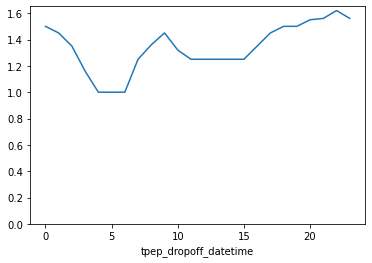

In [7]:
df.groupby(df["tpep_dropoff_datetime"].dt.hour)["tip_amount"].median().plot.line(ylim=0)

The data we are using here is the data for _one_ month. The NYC Taxi data is, however, available for many years. 

If we look at the memory usage of the DataFrame for a single month, we can see that the data for multiple years won't fit into the memory of a typical laptop:

In [8]:
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8759874 entries, 0 to 8759873
Data columns (total 17 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        int64         
 4   trip_distance          float64       
 5   RatecodeID             int64         
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
dtypes: datetime64[ns](2), float64(8), int64(6), object(1)
memory usag

In the next section, we will use a 2 year subset of the NYC Taxi data, already written as a partitioned Parquet dataset.

## Using dask for working with larger-than-memory data

Using `dask.dataframe` instead of `pandas` to read the directory of parquet files:

In [1]:
import dask.dataframe as dd

In [2]:
ddf = dd.read_parquet("data/nyc_taxi/dataset", split_row_groups=10)

In [3]:
ddf

,vendor_id,pickup_at,dropoff_at,passenger_count,trip_distance,rate_code_id,store_and_fwd_flag,pickup_location_id,dropoff_location_id,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,year,month
npartitions=341,,,,,,,,,,,,,,,,,,,
,object,datetime64[ns],datetime64[ns],int8,float32,object,object,int32,int32,object,float32,float32,float32,float32,float32,float32,float32,category[known],category[known]
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


The two years of data (2017-2018) contain  200+ million rows:

In [4]:
len(ddf["passenger_count"])

216301124

Let's compute again the average passenger count:

In [5]:
result = ddf["passenger_count"].mean()
result

dd.Scalar<series-..., dtype=float64>

This returned a lazy object, and not yet computed the actual average. Let's explicitly compute it:

In [6]:
result.compute()

1.6108773618763073

Dask supports almost the full pandas API, and so everything we have learned about pandas, we can re-use here. Let's also repeat the groupby operation:

In [7]:
# I am manually selecting the columns that I need here to reduce the read time
ddf = dd.read_parquet("data/nyc_taxi/dataset", split_row_groups=10, columns=["dropoff_at", "tip_amount"])

In [8]:
tip_by_hour_of_day_lazy = ddf.groupby(ddf["dropoff_at"].dt.hour)["tip_amount"].mean()
tip_by_hour_of_day_lazy

Dask Series Structure:
npartitions=1
    float64
        ...
Name: tip_amount, dtype: float64
Dask Name: truediv, 1806 tasks

In [9]:
%%time
tip_by_hour_of_day = tip_by_hour_of_day_lazy.compute()
tip_by_hour_of_day

CPU times: user 1min, sys: 3.92 s, total: 1min 4s
Wall time: 11.3 s


dropoff_at
0     2.039917
1     1.899012
2     1.729476
3     1.633067
4     1.684502
5     1.925685
6     1.702596
7     1.668924
8     1.771345
9     1.823205
10    1.758936
11    1.731408
12    1.733804
13    1.750615
14    1.780526
15    1.805137
16    1.921073
17    1.926160
18    1.924645
19    1.904398
20    1.904320
21    1.963552
22    2.014762
23    2.048015
Name: tip_amount, dtype: float64

This takes some time, but it did run on my laptop even while the dataset did not fit in the memory of my laptop.

### How does this work under the hood?

From https://docs.dask.org/en/stable/dataframe.html

Dask DataFrames coordinate many Pandas DataFrames/Series arranged along the index. A Dask DataFrame is partitioned row-wise. These Pandas objects may live on disk or on other machines:

<img src="https://docs.dask.org/en/stable/_images/dask-dataframe.svg" alt="drawing" style="width:500px;"/>

An operation on such a partitioned Dask DataFrame creates a task graph, which is then executed by one of the schedulers.

In [10]:
ddf = dd.read_parquet("data/nyc_taxi/dataset/year=2018/month=01/data.parquet", split_row_groups=30)

In [11]:
ddf

,vendor_id,pickup_at,dropoff_at,passenger_count,trip_distance,rate_code_id,store_and_fwd_flag,pickup_location_id,dropoff_location_id,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,year,month
npartitions=5,,,,,,,,,,,,,,,,,,,
,object,datetime64[ns],datetime64[ns],int8,float32,object,object,int32,int32,object,float32,float32,float32,float32,float32,float32,float32,category[known],category[known]
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


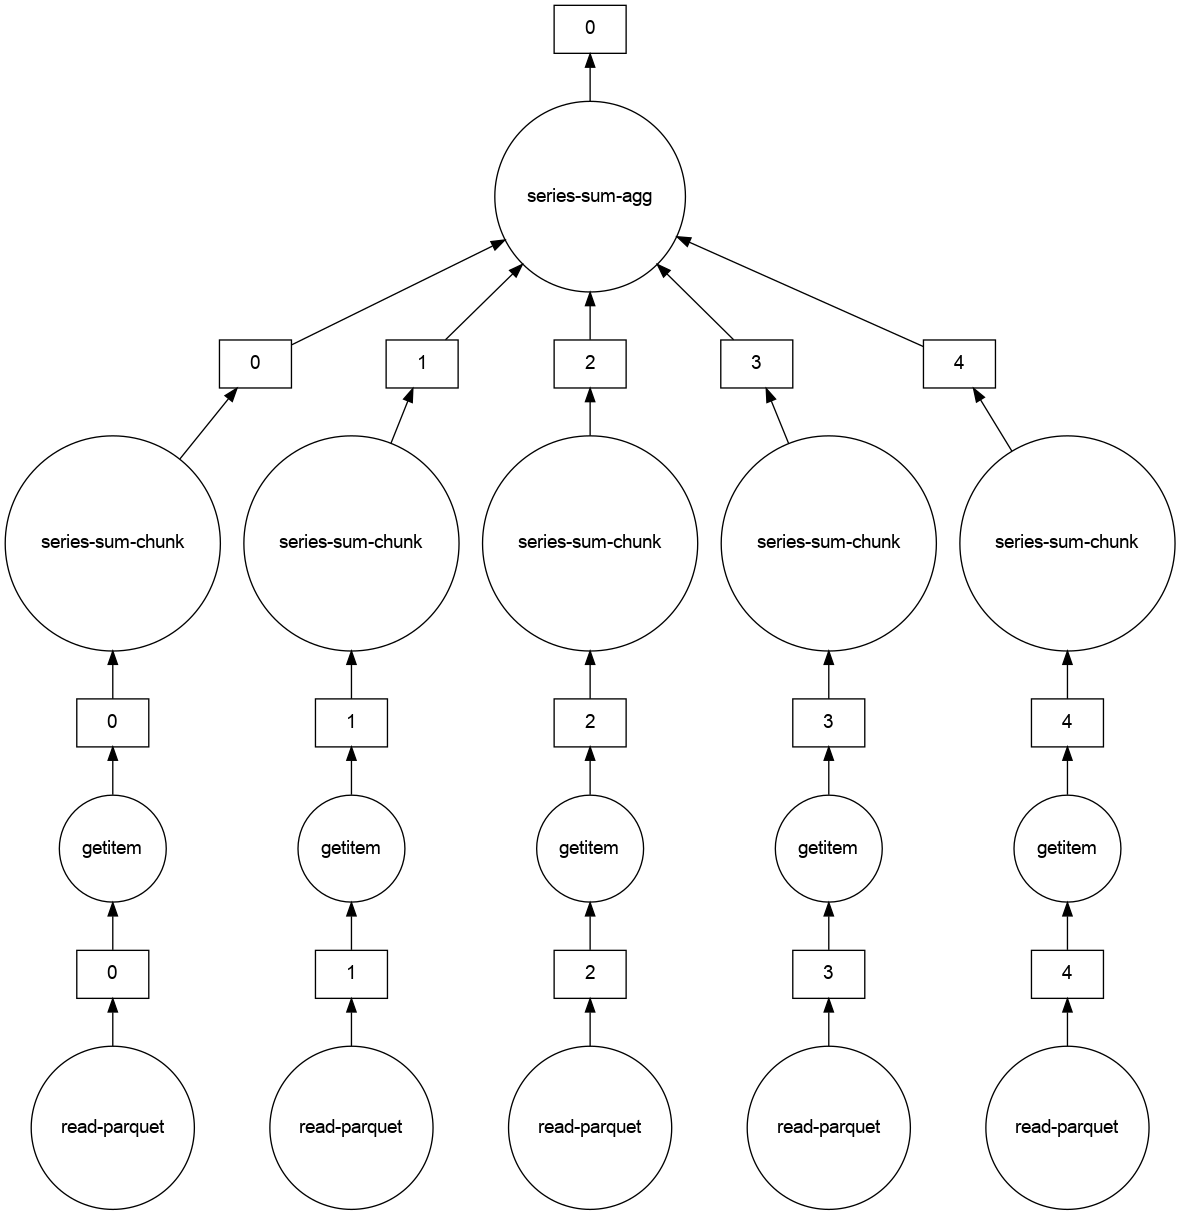

In [12]:
ddf["passenger_count"].sum().visualize()  # mean()

Using the distributed scheduler, but with a "local" cluster, we can use the diagnostics tools to better inspect what is happening:

In [13]:
from dask.distributed import Client, LocalCluster
client = Client(LocalCluster())
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 15.30 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42231,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 15.30 GiB
Comm: tcp://127.0.0.1:34621,Total threads: 2
Dashboard: http://127.0.0.1:34335/status,Memory: 3.82 GiB
Nanny: tcp://127.0.0.1:38185,


In [14]:
ddf = dd.read_parquet("data/nyc_taxi/dataset", split_row_groups=10, columns=["dropoff_at", "tip_amount"])
ddf.groupby(ddf["dropoff_at"].dt.hour)["tip_amount"].mean().compute()

dropoff_at
0     2.039917
1     1.899012
2     1.729476
3     1.633067
4     1.684502
5     1.925685
6     1.702596
7     1.668924
8     1.771345
9     1.823205
10    1.758936
11    1.731408
12    1.733804
13    1.750615
14    1.780526
15    1.805137
16    1.921073
17    1.926160
18    1.924645
19    1.904398
20    1.904320
21    1.963552
22    2.014762
23    2.048015
Name: tip_amount, dtype: float64

## Take home message

As a summary, using dask with pandas allows:

- to use the familiar pandas workflows for larger data as well
- to parallelize an analysis and/or work with larger-than-memory data 
- use the same code to work on our laptop or on a big cluster
